In [1]:
# %load hw1.py
import urllib.request
from numpy.lib.function_base import append  # lib that handles URLs
import pandas as pd
import re
import jieba
import jieba.analyse
import math

In [2]:
target_url = "https://raw.githubusercontent.com/cjwu/cjwu.github.io/master/courses/nlp/hw1-dataset.txt"
data = urllib.request.urlopen(target_url)

with open('output.txt', 'a+') as f:
    for line in data:
        decoded_line = line.decode("utf-8")
        f.write(decoded_line)

In [3]:
df = pd.read_fwf('./output.txt',header = None)
df.columns = ['content']
df.to_csv('./log.csv', encoding = 'utf-8',index = True)

In [15]:
class WordSegment:
    def __init__(self,texts,stop_words_path,dicts_path=""):
        self.jieba = jieba
        self.texts = texts
        self.dicts_path = dicts_path
        self.stop_words_path = stop_words_path
        
    def read_dictionary(self): 
        #讀取類別
        if self.dicts_path:
            for dic in self.dicts_path:
                self.jieba.load_userdict(dic)

    def read_stop_words(self):
        #讀取stopword
        self.stop_words = set()
        if stop_words_path:
            with open(stop_words_path,encoding = 'UTF-8') as file:
                self.stop_words = self.stop_words | set(map(str.strip,file.readlines()))
        
    def remove_stop_words(self):
        # 去除繁體中文以外的英文、數字、符號
        jieba.set_dictionary('./dict.txt.big')
        rule = re.compile(r"[^\u4e00-\u9fa5]")
        self.texts = [list(self.jieba.cut(rule.sub('', text))) for text in self.texts]
        for idx, speech in enumerate(self.texts):
            self.texts[idx] = ' '.join([word for word in speech if word.strip() not in self.stop_words])

In [8]:
topic = {}
with open('log.csv', newline='') as f:
    contents = ""
    for i,line in enumerate(f.readlines()):
        if i==0:continue
        ind, content = line.split(",",1)
        contents = content
        topic[ind] = content
#print(topic)

In [16]:
jieba.setLogLevel(jieba.logging.INFO)
stop_words_path = './stop_words.txt'

ws = WordSegment(topic.values(),stop_words_path)
ws.read_stop_words()
ws.remove_stop_words()
text_files = [text.split(" ") for text in ws.texts]

In [19]:
#計算每行詞次數
words_count = []
for file in text_files:
    count = {}
    for word in file:
        if word in count:
            count[word] += 1
        else:
            count[word] = 1
    words_count.append(count)

In [20]:
#統計每個語詞的頻率(次數/全部語詞次數)tf
words_frequency = []
for word_count in words_count:
    all_count = sum(word_count.values()) #該行所有語詞的數量
    fre = {}
    for word,count in word_count.items():
        fre[word] = round(count/all_count,4)
    words_frequency.append(fre)

In [66]:
#idf 
#先取得包含該語詞的文件數量
#就是該語詞在幾個文件中"出現過"
all_words = []
for word in words_count:
    all_words.extend(list(word.keys()))
    
occurrences_of_word = {}
for word in all_words:
    if word in occurrences_of_word:
        occurrences_of_word[word] += 1
    else:
        occurrences_of_word[word] = 1

freq_word = []
for word, freq in occurrences_of_word.items():

    freq_word.append((word, freq))

freq_word.sort(key = lambda x: x[1], reverse = True) #反序排列，根據第二個參數
X = []
Y = []
i=0
print('高頻:')
for word, freq in freq_word[: 100]:
    print(i,word, (freq/len(words_count)))
    X.append(i)
    Y.append(freq/len(words_count))
    i = i+1

高頻:
0 八卦 0.18630709561408124
1 有沒有 0.17173279898230998
2 什麼 0.15150334049095893
3 有 0.13694578218181644
4 你 0.13388266914075017
5 人 0.128552708977958
6 在 0.11504727380548156
7 我 0.11174025949182452
8 會 0.09836394852248435
9 不 0.08814400696314222
10 要 0.08622149104977977
11 好 0.08410289764276593
12 跟 0.07631001286459653
13 台灣 0.07578156010731656
14 去 0.07413642211180244
15 為 0.07209434675109158
16 也 0.05700594449572216
17 說 0.05646314460476038
18 沒 0.05325177784898207
19 可以 0.05287636118430806
20 是不是 0.051130793253021264
21 怎麼 0.0505043017489156
22 到 0.04744836227469022
23 想 0.04559279965184289
24 肥宅 0.043703760383738
25 吃 0.04021979808800532
26 現在 0.04016719193117202
27 看 0.03864639576090023
28 真的 0.037070602244848185
29 才 0.03313948761603244
30 他 0.033067751947623396
31 比較 0.03297210438974467
32 不會 0.03270907360557816
33 中國 0.032379089530896556
34 知道 0.0321423618251467
35 怎麼辦 0.0309085083285111
36 自己 0.029567051329261934
37 誰 0.029260979144050004
38 沒有 0.028507754625755017
39 多 0.0282

In [67]:
#文本數量/包含該語詞的數量
#就是行數量/該語詞在幾個文章中"出現過"
inverse_document_frequency = []     
for word_count in words_count:
    invFre = {} 
    for word in word_count.keys():
        occurrences = occurrences_of_word[word]
        invFre[word] = math.log(round((len(words_count)/occurrences),4))
    inverse_document_frequency.append(invFre)

#tf*idf
all_tf_idf = []
for i,words in enumerate(words_frequency):
    tf_idf = {}
    for word,freq in words.items():
        tf_idf[word] = freq*inverse_document_frequency[i][word]
    all_tf_idf.append(tf_idf)

super_dict = {}
for d in all_tf_idf:
    for k, v in d.items():
        super_dict[k] = v


In [68]:
print(Y)

[0.18630709561408124, 0.17173279898230998, 0.15150334049095893, 0.13694578218181644, 0.13388266914075017, 0.128552708977958, 0.11504727380548156, 0.11174025949182452, 0.09836394852248435, 0.08814400696314222, 0.08622149104977977, 0.08410289764276593, 0.07631001286459653, 0.07578156010731656, 0.07413642211180244, 0.07209434675109158, 0.05700594449572216, 0.05646314460476038, 0.05325177784898207, 0.05287636118430806, 0.051130793253021264, 0.0505043017489156, 0.04744836227469022, 0.04559279965184289, 0.043703760383738, 0.04021979808800532, 0.04016719193117202, 0.03864639576090023, 0.037070602244848185, 0.03313948761603244, 0.033067751947623396, 0.03297210438974467, 0.03270907360557816, 0.032379089530896556, 0.0321423618251467, 0.0309085083285111, 0.029567051329261934, 0.029260979144050004, 0.028507754625755017, 0.028239941463694577, 0.027962563545846267, 0.027065867690733186, 0.026611541790809226, 0.02571006355780221, 0.025253346468931282, 0.024999880440552652, 0.024732067278492212, 0.024

<BarContainer object of 100 artists>

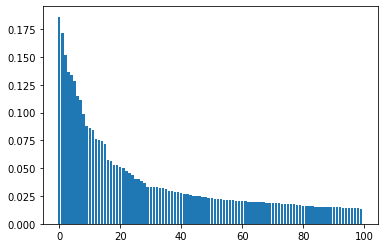

In [69]:
import matplotlib.pylab as plt
plt.bar(X,Y)

In [63]:
L = sorted(super_dict.items(),key=lambda item:item[1],reverse=True)

X = []
Y = []
i=0
print('weight hight:')
for word, freq in L[:100]:
    X.append(i)
    Y.append(freq)
    print(i,word, freq)
    i = i+1

weight hight:
0 咪姆宅 12.943719848366
1 收悉 12.943719848366
2 戊戌 12.943719848366
3 吉吉吉覆吉吉 12.943719848366
4 曹長 12.943719848366
5 圖咧文 12.943719848366
6 喇喇喇喇喇喇喇 12.943719848366
7 愛玩耍 12.943719848366
8 偽鈔 12.943719848366
9 角速度 12.943719848366
10 推三小三小 12.943719848366
11 斯洛伐克 12.250572667806054
12 泰拉 12.250572667806054
13 柔珠 11.557425487246109
14 搖起來 11.151960378659707
15 岡本 10.864278306686163
16 反田 10.3549758786928
17 海闊天空 10.304662517794265
18 簽拉 9.625274945095216
19  9.072518841284012
20 輝輝輝 8.629578022905612
21 哈連雞 8.629578022905612
22 皮豆 8.321517490514502
23 甲殼蟲樂隊 6.471859924183
24 兇宅夜 6.471859924183
25 歌太早 6.471859924183
26 阿輝 6.471859924183
27 韋廷 6.471859924183
28 海灣 6.471859924183
29 電和聯電 6.471859924183
30 帥之形 6.471859924183
31 糖三淆 6.471859924183
32 鼠鼠王 6.471859924183
33 董滋 6.471859924183
34 嘻三小糙 6.471859924183
35 動漫卡通 6.471859924183
36 羽彩 6.471859924183
37 嘴破還 6.471859924183
38 估摸 6.471859924183
39 問鄒智全 6.471859924183
40 公三小喇蛤 6.471859924183
41 天鬧板 6.471859924183
42 傘肥刀 6.47185992418

In [48]:
print(Y)

[12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.943719848366, 12.250572667806054, 12.250572667806054, 11.557425487246109, 11.151960378659707, 10.864278306686163, 10.3549758786928, 10.304662517794265, 9.625274945095216, 9.072518841284012, 8.629578022905612, 8.629578022905612, 8.321517490514502, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.471859924183, 6.4

<BarContainer object of 100 artists>

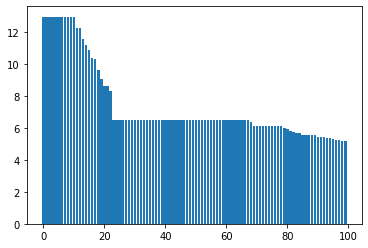

In [60]:
import matplotlib.pylab as plt
plt.bar(X,Y)